# 🧠 Masked Autoregressive Flow (MAF) for Anomaly Detection

### **Artin Tavasoli**
### 📘 Student ID: 810102543
### 1. Overview

We implement a **Masked Autoregressive Flow (MAF)** model for the task of anomaly detection on the **MVTec AD** dataset, specifically the capsule class.

Normalizing Flows, such as MAF, are capable of learning exact likelihoods of data distributions by transforming a simple base distribution (like a Gaussian) into a complex data distribution using a series of invertible mappings.

**Dataset:**
* **Name:** MVTec AD (Capsule Class)
* **Description:** A dataset designed for industrial anomaly detection, containing high-resolution images of manufactured capsules.
* **Training Set:** Contains only "good" (defect-free) images.
* **Test Set:** Contains both "good" images and various defect types (e.g., crack, faulty imprint, poke, scratch, squeeze).



In [ ]:
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

BASE_PATH = '/kaggle/input/mvtec-ad'

TRAIN_DIR = os.path.join(BASE_PATH, 'capsule', 'train')
TEST_DIR = os.path.join(BASE_PATH, 'capsule', 'test')

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

train_dataset = datasets.ImageFolder(root=TRAIN_DIR, transform=transform)

test_dataset = datasets.ImageFolder(root=TEST_DIR, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

print(f"Training on {len(train_dataset)} normal images.")
print(f"Testing on {len(test_dataset)} mixed images.")

Training on 219 normal images.
Testing on 132 mixed images.


### 2. Model Architecture
* The core building block of MAF used is the **Masked Autoencoder for Distribution Estimation (MADE)**.

* A MaskedLinear layer was implemented to apply masks to the weights of standard linear layers, enforcing the autoregressive property.

  This ensures that the $i$-th output depends only on inputs $1$ to $i-1$:

  $$p(x_i | x_{1:i-1})$$
* The MADE class constructs a neural network using these masked layers.
  
  It takes an input dimension and outputs parameters (mean $\mu$ and log-scale $\alpha$) for the affine transformation of the flow.

* The network structure consists of an input layer, hidden layers (size 512), and an output layer of size $2 \times$ Input Dimension.



In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class MaskedLinear(nn.Linear):
    def __init__(self, in_ch, out_ch, bias=True):
        super().__init__(in_ch, out_ch, bias)
        self.register_buffer('mask_matrix', torch.ones(out_ch, in_ch))

    def assign_mask(self, np_mask):
        tensor_m = torch.from_numpy(np_mask.astype(np.uint8))
        self.mask_matrix.data.copy_(tensor_m)

    def forward(self, x):
        w_masked = self.mask_matrix * self.weight
        return F.linear(x, w_masked, self.bias)

def _gen_degrees(dim, hidden_units):
    d_in = np.arange(dim)
    d_h1 = np.random.randint(0, dim - 1, hidden_units)
    d_h2 = np.random.randint(0, dim - 1, hidden_units)

    m1 = (d_h1[:, None] >= d_in[None, :]).astype(np.float32)
    m2 = (d_h2[:, None] >= d_h1[None, :]).astype(np.float32)

    m3_base = (d_in[:, None] > d_h2[None, :]).astype(np.float32)
    m3 = np.concatenate([m3_base, m3_base], axis=0)

    return m1, m2, m3

class MADE(nn.Module):
    def __init__(self, dim_in):
        super().__init__()
        self.dim = dim_in
        self.hidden = 512

        self.fc1 = MaskedLinear(dim_in, self.hidden)
        self.fc2 = MaskedLinear(self.hidden, self.hidden)
        self.fc3 = MaskedLinear(self.hidden, dim_in * 2)

        self.act = nn.ReLU()
        self._build_masks()

    def _build_masks(self):
        m1, m2, m3 = _gen_degrees(self.dim, self.hidden)
        self.fc1.assign_mask(m1)
        self.fc2.assign_mask(m2)
        self.fc3.assign_mask(m3)

    def forward(self, x):
        h = self.act(self.fc1(x))
        h = self.act(self.fc2(h))
        out = self.fc3(h)
        mu, log_alpha = torch.chunk(out, 2, dim=1)
        return mu, log_alpha

### 3. MAF
* The MAF class stacks 7 MADE blocks.

* Between each block, the order of input dimensions is reversed to ensure all dimensions can influence each other, enhancing the model's expressiveness.

* The **Forward Pass (Density Estimation)** transforms data $x$ to latent variable $z$. The relationship for each dimension $i$ is given by:
  $$u_i = (x_i - \mu_i(x_{<i})) \cdot \exp(-\alpha_i(x_{<i}))$$
  where $\mu$ and $\alpha$ are the outputs of the MADE network.

* The log-determinant of the Jacobian for this transformation is simply the sum of the log-scale terms:
  $$\log \left| \det \frac{\partial \mathbf{u}}{\partial \mathbf{x}} \right| = -\sum_{i} \alpha_i$$

* The final log-likelihood is computed as:
  $$\log p(x) = \log p(z) + \sum_{k=1}^{K} \log \left| \det J_k \right|$$
  where $K$ is the number of flow blocks.



In [ ]:
class MAF(nn.Module):
    def __init__(self, dim, n_layers=7):
        super().__init__()
        self.dim = dim
        self.n_layers = n_layers
        self.layers = nn.ModuleList()

        for _ in range(n_layers):
            self.layers.append(MADE(dim))

    def _forward_step(self, x, layer_net):
        mu, log_a = layer_net(x)
        inv_scale = torch.exp(-log_a)
        z = (x - mu) * inv_scale
        det = -torch.sum(log_a, dim=1)
        return z, det

    def _base_dist_log_prob(self, z):
        c = np.log(2 * np.pi)
        lp = -0.5 * (z ** 2 + c)
        return torch.sum(lp, dim=1)

    def forward(self, x):
        accum_det = 0
        curr_x = x

        for idx, net in enumerate(self.layers):
            if idx % 2 == 1:
                curr_x = torch.flip(curr_x, dims=[1])

            curr_x, step_det = self._forward_step(curr_x, net)
            accum_det += step_det

        z_final = curr_x
        log_prob_z = self._base_dist_log_prob(z_final)

        return log_prob_z + accum_det

### 4. Training Pipeline
* **Hyperparameters:** Learning Rate = $10^{-4}$, Epochs = 100, Input Dimension = $128 \times 128 \times 3 = 49,152$.
* **Loss Function:** Negative Log-Likelihood (NLL). Minimizing NLL maximizes the likelihood of the training data under the model:
  $$\mathcal{L}(\theta) = -\frac{1}{N} \sum_{i=1}^{N} \log p_\theta(x^{(i)})$$
* **Optimization:** The Adam optimizer was used.





Compute target: cuda
Launching training sequence...


Ep 1 | Avg NLL: 27955.3900


Ep 2 | Avg NLL: -34729.9410


Ep 3 | Avg NLL: -69437.3262


Ep 4 | Avg NLL: -91638.1191


Ep 5 | Avg NLL: -102790.4071


Ep 6 | Avg NLL: -111134.4361


Ep 7 | Avg NLL: -91537.6310


Ep 8 | Avg NLL: -111423.2648


Ep 9 | Avg NLL: -122281.4774


Ep 10 | Avg NLL: -121818.4202


Ep 11 | Avg NLL: -128162.9171


Ep 12 | Avg NLL: -129647.6071


Ep 13 | Avg NLL: -131756.3828


Ep 14 | Avg NLL: -134638.9685


Ep 15 | Avg NLL: -135017.6108


Ep 16 | Avg NLL: -140630.7321


Ep 17 | Avg NLL: -139669.7134


Ep 18 | Avg NLL: -131616.0170


Ep 19 | Avg NLL: -140300.9838


Ep 20 | Avg NLL: -140035.7935


Ep 21 | Avg NLL: -141302.6454


Ep 22 | Avg NLL: -141501.3108


Ep 23 | Avg NLL: -143789.8041


Ep 24 | Avg NLL: -145201.6786


Ep 25 | Avg NLL: -146167.8767


Ep 26 | Avg NLL: -147261.6680


Ep 27 | Avg NLL: -146950.3493


Ep 28 | Avg NLL: -146669.9157


Ep 29 | Avg NLL: -129673.4129


Ep 30 | Avg NLL: -100560.1180


Ep 31 | Avg NLL: -133246.1110


Ep 32 | Avg NLL: -145000.6624


Ep 33 | Avg NLL: -147917.1618


Ep 34 | Avg NLL: -150303.9414


Ep 35 | Avg NLL: -151381.8934


Ep 36 | Avg NLL: -151314.0324


Ep 37 | Avg NLL: -150771.3845


Ep 38 | Avg NLL: -151578.8225


Ep 39 | Avg NLL: -154638.0497


Ep 40 | Avg NLL: -154113.3097


Ep 41 | Avg NLL: -146969.8186


Ep 42 | Avg NLL: -152197.1267


Ep 43 | Avg NLL: -155446.7556


Ep 44 | Avg NLL: -155354.7846


Ep 45 | Avg NLL: -153043.3856


Ep 46 | Avg NLL: -155483.4308


Ep 47 | Avg NLL: -155757.0201


Ep 48 | Avg NLL: -156496.1607


Ep 49 | Avg NLL: -157486.5234


Ep 50 | Avg NLL: -156088.4297


Ep 51 | Avg NLL: -157110.9051


Ep 52 | Avg NLL: -157543.2260


Ep 53 | Avg NLL: -156700.7533


Ep 54 | Avg NLL: -156932.0647


Ep 55 | Avg NLL: -132881.6543


Ep 56 | Avg NLL: -135645.3962


Ep 57 | Avg NLL: -156000.3756


Ep 58 | Avg NLL: -159211.6551


Ep 59 | Avg NLL: -146544.2062


Ep 60 | Avg NLL: -136902.6127


Ep 61 | Avg NLL: -156790.0893


Ep 62 | Avg NLL: -157394.9035


Ep 63 | Avg NLL: -159446.7148


Ep 64 | Avg NLL: -159776.0765


Ep 65 | Avg NLL: -161319.2450


Ep 66 | Avg NLL: -162070.0028


Ep 67 | Avg NLL: -160585.6836


Ep 68 | Avg NLL: -160949.7528


Ep 69 | Avg NLL: -161509.0592


Ep 70 | Avg NLL: -161779.1233


Ep 71 | Avg NLL: -161992.4526


Ep 72 | Avg NLL: -163679.6674


Ep 73 | Avg NLL: -162401.9141


Ep 74 | Avg NLL: -163012.1903


Ep 75 | Avg NLL: -163669.3756


Ep 76 | Avg NLL: -163932.2483


Ep 77 | Avg NLL: -162809.1172


Ep 78 | Avg NLL: -163845.3131


Ep 79 | Avg NLL: -163134.7316


Ep 80 | Avg NLL: -164366.7695


Ep 81 | Avg NLL: -165132.1490


Ep 82 | Avg NLL: -165883.0675


Ep 83 | Avg NLL: -164362.9481


Ep 84 | Avg NLL: -163560.8203


Ep 85 | Avg NLL: -163915.9090


Ep 86 | Avg NLL: -165393.8549


Ep 87 | Avg NLL: -165833.6669


Ep 88 | Avg NLL: -166618.1741


Ep 89 | Avg NLL: -166612.8538


Ep 90 | Avg NLL: -166441.3929


Ep 91 | Avg NLL: -167017.8371


Ep 92 | Avg NLL: -167032.6518


Ep 93 | Avg NLL: -166569.9141


Ep 94 | Avg NLL: -167240.0033


Ep 95 | Avg NLL: -155868.0698


Ep 96 | Avg NLL: -143908.1613


Ep 97 | Avg NLL: -163653.7857


Ep 98 | Avg NLL: -166498.1786


Ep 99 | Avg NLL: -167836.0675


Ep 100 | Avg NLL: -167372.9760
Training Complete. Duration: 1782.62s


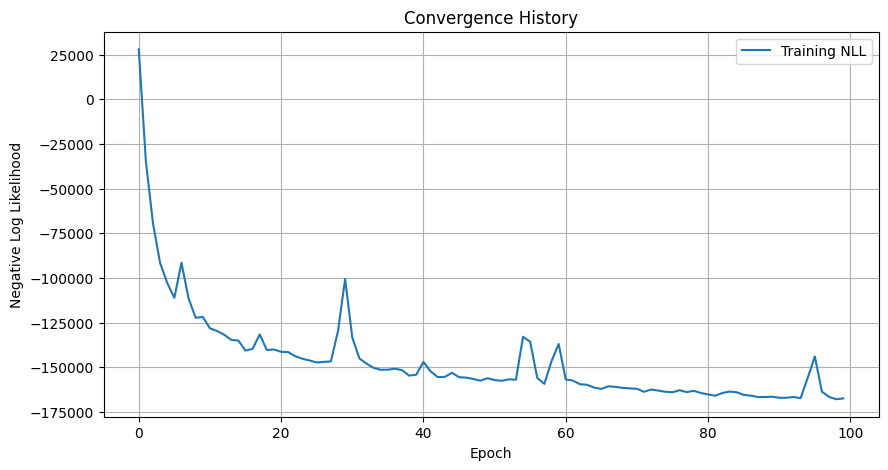

Model saved successfully as 'maf_weights.pth'


In [ ]:
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
import os

learning_rate = 0.0001
num_epochs = 100
input_dimensionality = 128 * 128 * 3

print(f"Compute target: {device}")

model_maf = MAF(input_dimensionality, n_layers=7).to(device)
optimizer = optim.Adam(model_maf.parameters(), lr=learning_rate)

loss_history = []
start_timestamp = time.time()

print("Launching training sequence...")

for current_epoch in range(num_epochs):
    model_maf.train()
    accumulated_loss = 0.0

    progress_bar = tqdm(train_loader, leave=False, desc=f"Ep {current_epoch+1}/{num_epochs}")

    for _, (image_batch, _) in enumerate(progress_bar):
        image_batch = image_batch.to(device)
        flattened_input = image_batch.view(image_batch.size(0), -1)

        optimizer.zero_grad()

        nll_value = -torch.mean(model_maf(flattened_input))

        nll_value.backward()
        optimizer.step()

        accumulated_loss += nll_value.item()
        progress_bar.set_postfix(nll=nll_value.item())

    epoch_avg_loss = accumulated_loss / len(train_loader)
    loss_history.append(epoch_avg_loss)
    print(f"Ep {current_epoch+1} | Avg NLL: {epoch_avg_loss:.4f}")

total_duration = time.time() - start_timestamp
print(f"Training Complete. Duration: {total_duration:.2f}s")

plt.figure(figsize=(10, 5))
plt.plot(loss_history, label='Training NLL')
plt.xlabel('Epoch')
plt.ylabel('Negative Log Likelihood')
plt.title('Convergence History')
plt.legend()
plt.grid(True)
plt.show()

torch.save(model_maf.state_dict(), 'maf_weights.pth')
print("Model saved successfully as 'maf_weights.pth'")

* **Result:** The training loss decreased significantly over 100 epochs, indicating that the model successfully learned the distribution of normal images.
    * **Timing:** The training process (density estimation) was fast, taking approximately **1782 seconds (~30 minutes)**.

## 5. Image Generation (Sampling)
* Sampling in MAF requires inverting the flow (Noise $\rightarrow$ Data). Due to the autoregressive nature, this inversion is **sequential** and cannot be parallelized.
* The inverse transformation for dimension $i$ is:
  $$x_i = z_i \cdot \exp(\alpha_i(x_{<i})) + \mu_i(x_{<i})$$
* Because $\mu_i$ and $\alpha_i$ depend on all previous pixels $x_{<i}$, each pixel must be generated one by one.

Using model from memory.
Visualizing 5 real reference images...


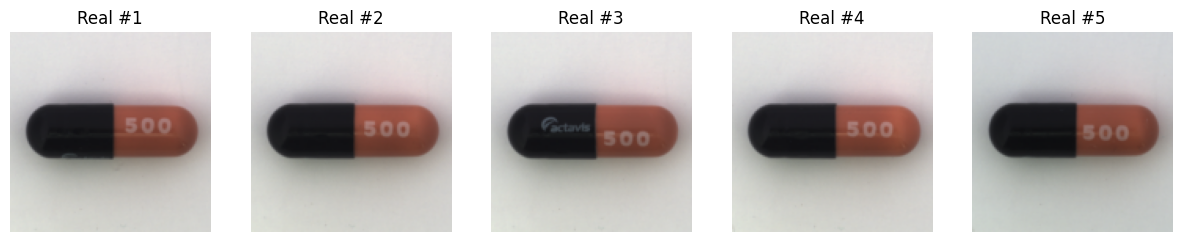

Initiating synthesis for 5 samples...

Processing Sample 1/5...
  > Inverting Layer 7...


  > Inverting Layer 6...


  > Inverting Layer 5...


  > Inverting Layer 4...


  > Inverting Layer 3...


  > Inverting Layer 2...


  > Inverting Layer 1...


  > Done in 1674.36s

Processing Sample 2/5...
  > Inverting Layer 7...


  > Inverting Layer 6...


  > Inverting Layer 5...


  > Inverting Layer 4...


  > Inverting Layer 3...


  > Inverting Layer 2...


  > Inverting Layer 1...


  > Done in 1674.45s

Processing Sample 3/5...
  > Inverting Layer 7...


  > Inverting Layer 6...


  > Inverting Layer 5...


  > Inverting Layer 4...


  > Inverting Layer 3...


  > Inverting Layer 2...


  > Inverting Layer 1...


  > Done in 1674.48s

Processing Sample 4/5...
  > Inverting Layer 7...


  > Inverting Layer 6...


  > Inverting Layer 5...


  > Inverting Layer 4...


  > Inverting Layer 3...


  > Inverting Layer 2...


  > Inverting Layer 1...


  > Done in 1674.53s

Processing Sample 5/5...
  > Inverting Layer 7...


  > Inverting Layer 6...


  > Inverting Layer 5...


  > Inverting Layer 4...


  > Inverting Layer 3...


  > Inverting Layer 2...


  > Inverting Layer 1...


  > Done in 1674.46s

TIMING REPORT
Sample 1: 1674.36 s
Sample 2: 1674.45 s
Sample 3: 1674.48 s
Sample 4: 1674.53 s
Sample 5: 1674.46 s
------------------------------
Total:    8374.06 s
Mean:     1674.81 s



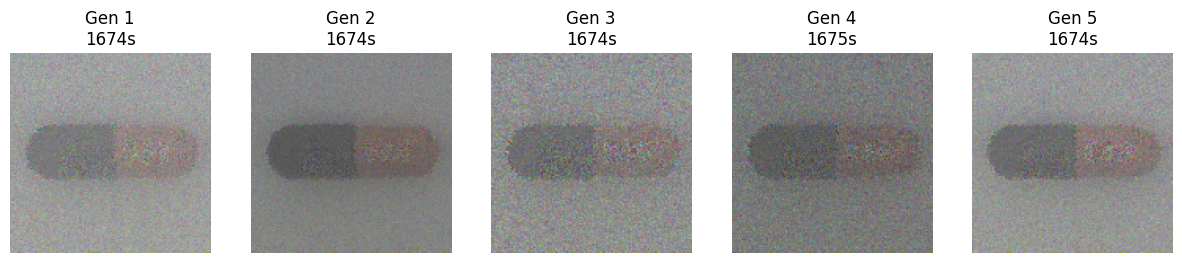

In [ ]:
import matplotlib.pyplot as plt
import torch
import numpy as np
import time
import os
from tqdm import tqdm

d_input = 128 * 128 * 3
if 'model_maf' not in globals():
    model_maf = MAF(d_input, n_layers=7).to(device)
    if os.path.exists('maf_weights.pth'):
        model_maf.load_state_dict(torch.load('maf_weights.pth', map_location=device))
        print("Loaded weights from disk.")
    else:
        print("Weights not found")
else:
    print("Using model from memory.")

def show_refs(data_loader, dev_obj, n=5):
    t_idx = 0
    if hasattr(data_loader.dataset, 'class_to_idx'):
        t_idx = data_loader.dataset.class_to_idx.get('good', 0)

    ref_list = []
    with torch.no_grad():
        for x_batch, y_batch in data_loader:
            goods = x_batch[y_batch == t_idx]
            for k in range(goods.size(0)):
                ref_list.append(goods[k])
                if len(ref_list) >= n: break
            if len(ref_list) >= n: break

    print(f"Visualizing {len(ref_list)} real reference images...")
    plt.figure(figsize=(15, 3))
    for j, im in enumerate(ref_list):
        im_np = im.permute(1, 2, 0).cpu().numpy()
        plt.subplot(1, n, j + 1)
        plt.imshow(im_np)
        plt.axis('off')
        plt.title(f"Real #{j+1}")
    plt.show()

if 'test_loader' in globals():
    show_refs(test_loader, device)

def _inv_pixel_loop(layer_node, z_in):
    x_out = torch.zeros_like(z_in)
    dim_len = z_in.shape[1]

    pbar = tqdm(range(dim_len), leave=False, desc="Computing Pixels")

    for px in pbar:
        mu, log_s = layer_node(x_out)
        s = torch.exp(log_s)
        x_out[:, px] = z_in[:, px] * s[:, px] + mu[:, px]

    return x_out

def run_synthesis(flow_net, dev, n_gen=5):
    flow_net.eval()
    flat_dim = 128 * 128 * 3

    out_imgs = []
    durations = []

    print(f"Initiating synthesis for {n_gen} samples...")
    t_start_total = time.time()

    for i in range(n_gen):
        print(f"\nProcessing Sample {i+1}/{n_gen}...")
        t0 = time.time()

        z = torch.randn(1, flat_dim).to(dev)
        curr = z.clone()

        with torch.no_grad():
            for l_idx, layer in enumerate(reversed(flow_net.layers)):
                l_real_idx = len(flow_net.layers) - 1 - l_idx
                print(f"  > Inverting Layer {l_real_idx + 1}...")

                curr = _inv_pixel_loop(layer, curr)

                if l_real_idx % 2 == 1:
                    curr = torch.flip(curr, dims=[1])

        dt = time.time() - t0
        durations.append(dt)

        arr = curr.view(3, 128, 128).permute(1, 2, 0).cpu().numpy()
        arr = (arr - arr.min()) / (arr.max() - arr.min())
        out_imgs.append(arr)

        print(f"  > Done in {dt:.2f}s")

    t_total = time.time() - t_start_total
    t_avg = t_total / n_gen

    return out_imgs, durations, t_total, t_avg

gen_res, gen_times, total_t, avg_t = run_synthesis(model_maf, device, n_gen=5)

print("\n" + "="*30)
print("TIMING REPORT")
print("="*30)
for k, val in enumerate(gen_times):
    print(f"Sample {k+1}: {val:.2f} s")
print("-" * 30)
print(f"Total:    {total_t:.2f} s")
print(f"Mean:     {avg_t:.2f} s")
print("="*30 + "\n")

plt.figure(figsize=(15, 3))
for k, im in enumerate(gen_res):
    plt.subplot(1, 5, k + 1)
    plt.imshow(im)
    plt.title(f"Gen {k+1}\n{gen_times[k]:.0f}s")
    plt.axis('off')
plt.show()

* **Result:**
    * Five samples were generated.
    * The generated images visually resembled capsules, capturing the general structure and color distribution, though they appeared noisy due to the bottleneck architecture (mapping 49k dimensions to 512 hidden units).
    * **Timing:** The generation process was extremely slow, taking approximately **1674 seconds (~28 minutes)** per image. This confirms the theoretical disadvantage of MAF: fast training (density estimation) but slow sampling.

### 6: Anomaly Detection Evaluation

* The model was evaluated on the test set containing both good and defective images.

* **Anomaly Score:** The Negative Log-Likelihood was used as the anomaly score $S(x)$:
    $$S(x) = -\log p(x)$$
    Normal images should have high likelihood (low score), while anomalies should have low likelihood (high score).



Starting evaluation...


Scanning: 100%|██████████| 17/17 [00:08<00:00,  1.97it/s]

AUROC Metric: 0.7830


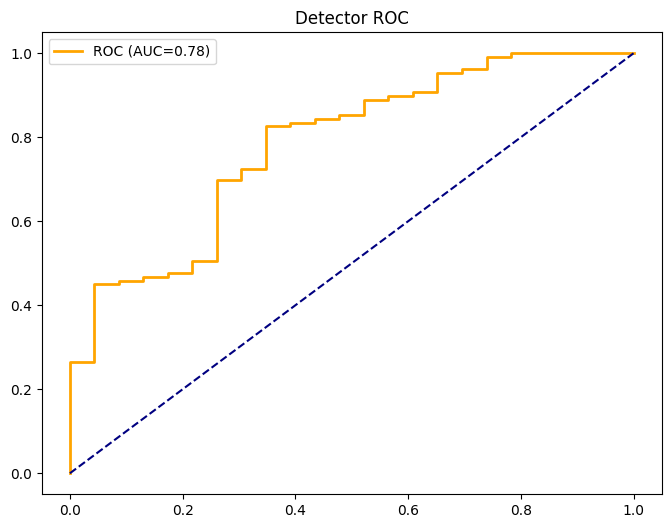

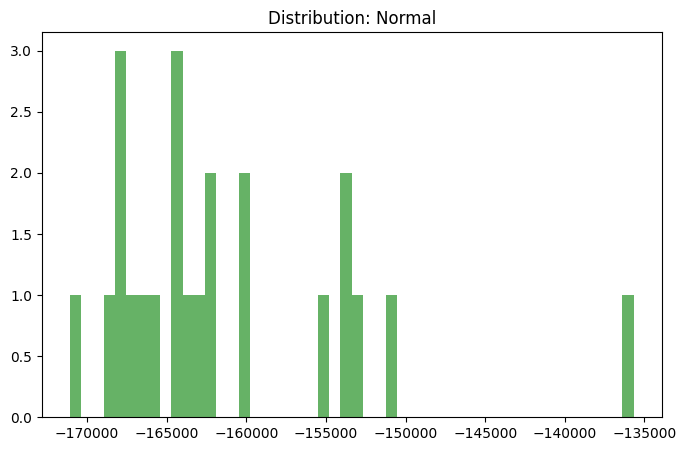

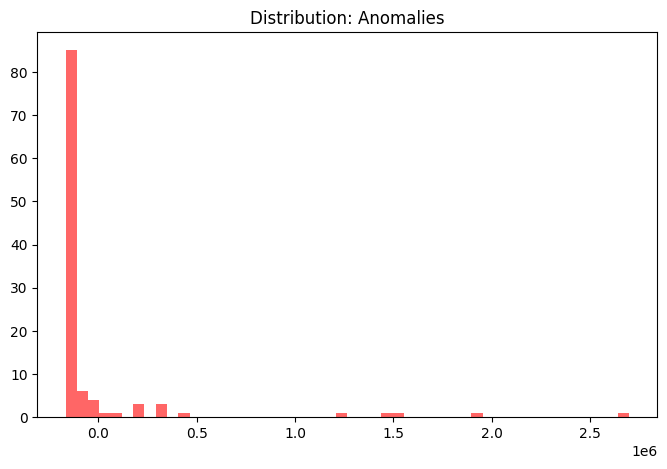

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve
import numpy as np

def run_evaluation(flow_net, loader, dev):
    flow_net.eval()

    labels_gt = []
    scores_nll = []

    if hasattr(loader.dataset, 'class_to_idx'):
        target_cls = loader.dataset.class_to_idx.get('good', 0)
    else:
        target_cls = 0

    print("Starting evaluation...")

    with torch.no_grad():
        for batch_img, batch_lbl in tqdm(loader, desc="Scanning"):
            batch_img = batch_img.to(dev)
            x_flat = batch_img.view(batch_img.size(0), -1)

            log_likelihood = flow_net(x_flat)

            anomaly_val = -log_likelihood

            scores_nll.extend(anomaly_val.cpu().numpy())

            bin_target = [0 if l.item() == target_cls else 1 for l in batch_lbl]
            labels_gt.extend(bin_target)

    auc_res = roc_auc_score(labels_gt, scores_nll)
    print(f"AUROC Metric: {auc_res:.4f}")

    return labels_gt, scores_nll, auc_res

gt, sc, auc_final = run_evaluation(model_maf, test_loader, device)

fpr, tpr, _ = roc_curve(gt, sc)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='orange', lw=2, label=f'ROC (AUC={auc_final:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.title('Detector ROC')
plt.legend()
plt.show()

np_s = np.array(sc)
np_g = np.array(gt)

plt.figure(figsize=(8, 5))
plt.hist(np_s[np_g==0], bins=50, color='green', alpha=0.6)
plt.title('Distribution: Normal')
plt.show()

plt.figure(figsize=(8, 5))
plt.hist(np_s[np_g==1], bins=50, color='red', alpha=0.6)
plt.title('Distribution: Anomalies')
plt.show()

* **Result:**
    * **AUROC:** The model achieved an AUROC of **0.7830**, demonstrating that the MAF model effectively learned to distinguish between normal and anomalous capsules based on their likelihood.
    * The histograms of anomaly scores showed a separation between normal (lower scores) and anomalous (higher scores) samples.
    

## 7. Finishing Statements.

The MAF model was successfully implemented and trained. It learned the distribution of normal capsule images effectively, as evidenced by the training 

loss and the high AUROC score (0.78) in the anomaly detection task.

We saw the trade-off of Autoregressive Flows. While training (density estimation) is efficient, sampling (generation) is computationally expensive and 

slow due to its sequential nature.

Likelihood-based methods like MAF offer a viable approach for unsupervised anomaly detection, assigning lower probabilities to unseen defect patterns 

compared to learned normal patterns.